<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/soil_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [91]:
# Define the generator model
def build_generator(latent_dim, sequence_length):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(sequence_length, activation='tanh')
    ])
    return model

In [92]:
# Define the discriminator model
def build_discriminator(sequence_length):
    model = models.Sequential([
        layers.Dense(1024, activation='relu', input_dim=sequence_length),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [93]:

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([
        generator,
        discriminator
    ])
    return model


In [94]:
# Update the training function to include validation
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, val_gen):
    for epoch in range(epochs):
        # Train on batches from the training generator
        for _ in range(len(train_sequences) // batch_size):
            # Generate fake sequences
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            fake_sequences = generator.predict(noise)

            # Get a batch of real sequences from the training generator
            real_sequences = next(train_gen)

            # Labels for real and fake data
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))

            # Train the discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
            d_loss = 0.5 * tf.add(d_loss_real, d_loss_fake)

            # Train the generator
            discriminator.trainable = False
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

        # Validation
        val_real_sequences = next(val_gen)
        val_fake_sequences = generator.predict(tf.random.normal(shape=(batch_size, latent_dim)))
        val_d_loss_real = discriminator.evaluate(val_real_sequences, tf.ones((batch_size, 1)), verbose=0)
        val_d_loss_fake = discriminator.evaluate(val_fake_sequences, tf.zeros((batch_size, 1)), verbose=0)
        val_d_loss = 0.5 * np.add(val_d_loss_real, val_d_loss_fake)

        # Print the progress
        print(f"Epoch: {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}, Val D Loss: {val_d_loss}")


        if epoch % 100 == 0:
          data = validate_generator()

          # Create a histogram
          plt.hist(data, bins=10, color='blue', edgecolor='black')

          # Add labels and title
          plt.xlabel('Value')
          plt.ylabel('Frequency')
          plt.title('Simple Histogram')

          # Show the plot
          plt.show()

In [97]:
def validate_generator(n_lowest = 10, n_samp = 1024*8 ):
  n_lowest = 10
  result_vec = []
  noise = tf.random.normal(shape=(n_samp, latent_dim))
  synthetic_samples = generator.predict(noise)
  batch_val = next(val_gen)
  for batch_ in batch_val:
    # batch_ = batch_val[1]
    match_indices = [0,1,2,3,5,6,7,8,9]

    data = [np.mean(np.sqrt((batch_[match_indices] - samp[match_indices])**2)) for samp in synthetic_samples]

    indices = sorted(range(len(data)), key=lambda i: data[i])[:n_lowest]

    most_similar = [synthetic_samples[i] for i in indices]

    most_similar_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in most_similar]

    original_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in [batch_]]

    most_similar_scaled_2d = [np.squeeze(sim) for sim in most_similar_scaled]

    original_scaled_2d = [np.squeeze(sim) for sim in original_scaled]

    most_similar_scaled_df = pd.DataFrame(most_similar_scaled_2d, columns=numeric_cols.columns)

    original_scaled_df = pd.DataFrame(original_scaled_2d, columns=numeric_cols.columns)

    result = np.sqrt((np.mean(most_similar_scaled_df['imp_c_float'])- np.mean(original_scaled_df['imp_c_float']))**2)
    # print(np.mean(original_scaled_df['agbd_m']))
    result_vec.append(result)
  return(result_vec)

In [9]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [10]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [11]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [12]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [32]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [33]:
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows

In [45]:
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

In [51]:
len(matched_data.select_dtypes(include=[np.number]).columns)

39

In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

# Select only numeric columns
numeric_cols = matched_data.select_dtypes(include=[np.number]).iloc[:,[6,7,8,9,10,11,12,13,14,38]]

# Initialize the scaler
scaler = MinMaxScaler ()

# Fit the scaler on the numeric columns
scaler.fit(numeric_cols)

# Transform the numeric columns
scaled_numeric_cols = scaler.transform(numeric_cols)

# Convert the scaled numeric columns back to a DataFrame
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df = scaled_numeric_df
# Concatenate the ID fields back with the numeric columns
numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [102]:
from tensorflow.keras.optimizers import Adam

# Set the dimensions and compile the models
latent_dim = 100
sequence_length = 10  # Adjust based on your sequence length

generator = build_generator(latent_dim, sequence_length)
discriminator = build_discriminator(sequence_length)
gan = build_gan(generator, discriminator)

# Set the initial learning rate
initial_learning_rate = 0.0002

# Create optimizers for the generator and discriminator
generator_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)
gan_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)

# Compile the discriminator
generator.compile(optimizer=generator_optimizer, loss='mse', metrics=['accuracy'])

# Compile the discriminator
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN
gan.compile(optimizer=gan_optimizer, loss='mse')

# # Assuming 'final_df' is your scaled dataset with numeric columns and ID fields
# # Extract only the numeric columns for the GAN
# numeric_columns = [col for col in scaled_numeric_cols.columns if scaled_numeric_cols[col].dtype in [np.float32, np.float64]]
# real_sequences_df = scaled_numeric_cols[numeric_columns]

# Convert the DataFrame to a NumPy array
real_sequences_array = scaled_numeric_cols

def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            yield batch


# Create an instance of the generator
# real_sequence_gen = real_sequence_generator(real_sequences_array, batch_size)


In [62]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

train_sequences, val_sequences = train_test_split(real_sequences_array, test_size=0.2, random_state=42)

test_sequences, val_sequences = train_test_split(val_sequences, test_size=0.5, random_state=42)

batch_size = 128  # Set the batch size


# Define the training and validation generators
train_gen = real_sequence_generator(train_sequences, batch_size)
test_gen = real_sequence_generator(test_sequences, batch_size)
val_gen = real_sequence_generator(val_sequences, batch_size)


4/4 [==============================] - 0s 8ms/step
Epoch: 1/10000, D Loss: [0.6973556  0.48828125], G Loss: 0.2734333872795105, Val D Loss: [0.69441858 0.51171875]
256/256 [==============================] - 1s 5ms/step


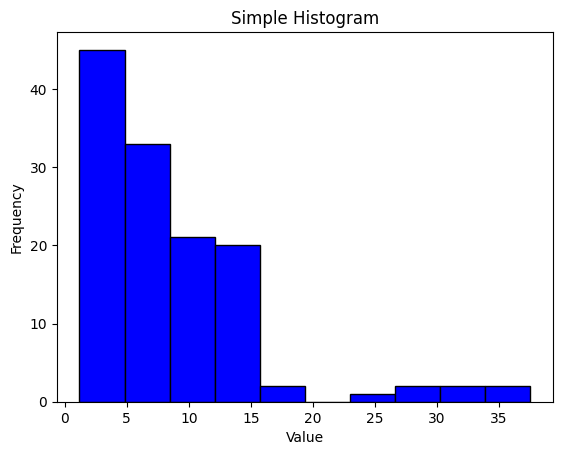

4/4 [==============================] - 0s 5ms/step
Epoch: 2/10000, D Loss: [0.69758636 0.48046875], G Loss: 0.2694886326789856, Val D Loss: [0.69528806 0.4609375 ]
4/4 [==============================] - 0s 5ms/step
Epoch: 3/10000, D Loss: [0.6970816  0.45703125], G Loss: 0.26859429478645325, Val D Loss: [0.69601041 0.3515625 ]
4/4 [==============================] - 0s 6ms/step
Epoch: 4/10000, D Loss: [0.6987122 0.4375   ], G Loss: 0.2702311873435974, Val D Loss: [0.69628817 0.328125  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 5/10000, D Loss: [0.69871074 0.4609375 ], G Loss: 0.26883190870285034, Val D Loss: [0.6967259 0.2578125]
4/4 [==============================] - 0s 10ms/step
Epoch: 6/10000, D Loss: [0.6978153 0.4453125], G Loss: 0.2697000205516815, Val D Loss: [0.69675899 0.2421875 ]
4/4 [==============================] - 0s 8ms/step
Epoch: 7/10000, D Loss: [0.6993809  0.41015625], G Loss: 0.26886269450187683, Val D Loss: [0.69689548 0.23828125]
4/4 [=============

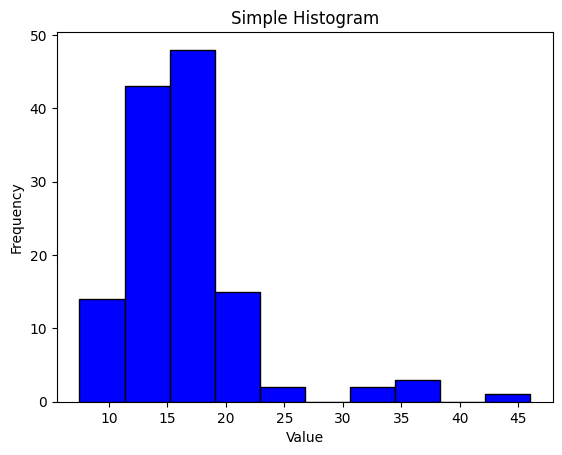

4/4 [==============================] - 0s 9ms/step
Epoch: 102/10000, D Loss: [0.6898435  0.42578125], G Loss: 0.2625875174999237, Val D Loss: [0.70158622 0.06640625]
4/4 [==============================] - 0s 6ms/step
Epoch: 103/10000, D Loss: [0.69104266 0.39453125], G Loss: 0.2620730400085449, Val D Loss: [0.70109522 0.09765625]
4/4 [==============================] - 0s 5ms/step
Epoch: 104/10000, D Loss: [0.6927953 0.390625 ], G Loss: 0.2585393190383911, Val D Loss: [0.70123869 0.0859375 ]
4/4 [==============================] - 0s 5ms/step
Epoch: 105/10000, D Loss: [0.6917752 0.3828125], G Loss: 0.2619507908821106, Val D Loss: [0.70169142 0.08984375]
4/4 [==============================] - 0s 6ms/step
Epoch: 106/10000, D Loss: [0.6896168 0.4296875], G Loss: 0.26057857275009155, Val D Loss: [0.70117068 0.09375   ]
4/4 [==============================] - 0s 6ms/step
Epoch: 107/10000, D Loss: [0.69205827 0.42578125], G Loss: 0.25919318199157715, Val D Loss: [0.7013391 0.078125 ]
4/4 [=====

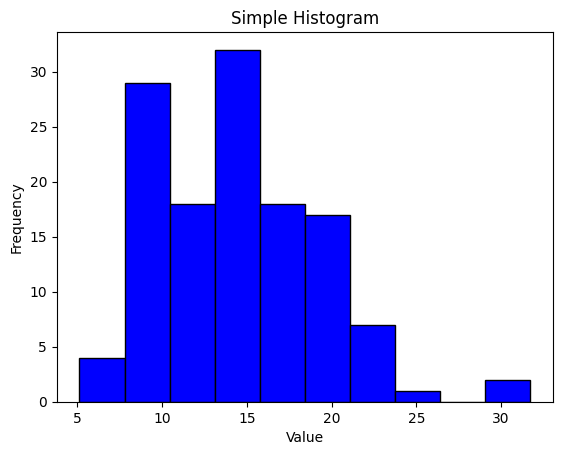

4/4 [==============================] - 0s 10ms/step
Epoch: 202/10000, D Loss: [0.6950617  0.36328125], G Loss: 0.25819358229637146, Val D Loss: [0.70074761 0.0859375 ]
4/4 [==============================] - 0s 6ms/step
Epoch: 203/10000, D Loss: [0.6909796 0.4296875], G Loss: 0.261025995016098, Val D Loss: [0.70066249 0.078125  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 204/10000, D Loss: [0.6952293 0.3828125], G Loss: 0.25725898146629333, Val D Loss: [0.70026618 0.125     ]
4/4 [==============================] - 0s 10ms/step
Epoch: 205/10000, D Loss: [0.69339037 0.39453125], G Loss: 0.2609134912490845, Val D Loss: [0.70098051 0.0859375 ]
4/4 [==============================] - 0s 8ms/step
Epoch: 206/10000, D Loss: [0.6936058  0.42578125], G Loss: 0.25926560163497925, Val D Loss: [0.70111322 0.08203125]
4/4 [==============================] - 0s 7ms/step
Epoch: 207/10000, D Loss: [0.6949603  0.36328125], G Loss: 0.26014792919158936, Val D Loss: [0.70130974 0.0625    ]
4/4

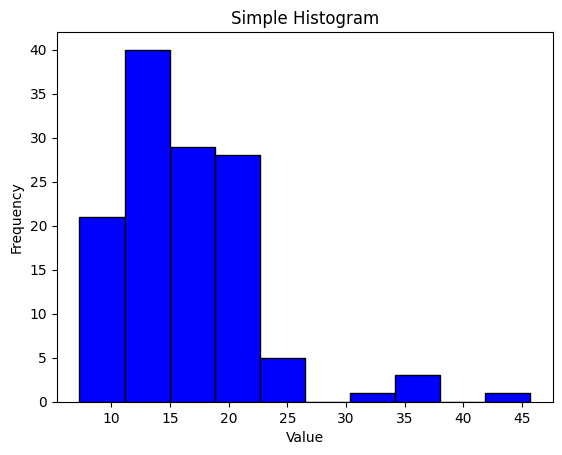

4/4 [==============================] - 0s 7ms/step
Epoch: 302/10000, D Loss: [0.69466746 0.390625  ], G Loss: 0.25657880306243896, Val D Loss: [0.70126221 0.05078125]
4/4 [==============================] - 0s 6ms/step
Epoch: 303/10000, D Loss: [0.69386417 0.41015625], G Loss: 0.2586315870285034, Val D Loss: [0.70123082 0.06640625]
4/4 [==============================] - 0s 6ms/step
Epoch: 304/10000, D Loss: [0.69359326 0.4375    ], G Loss: 0.2588541507720947, Val D Loss: [0.70095754 0.078125  ]
4/4 [==============================] - 0s 13ms/step
Epoch: 305/10000, D Loss: [0.69447327 0.390625  ], G Loss: 0.25687187910079956, Val D Loss: [0.70019773 0.08984375]
4/4 [==============================] - 0s 9ms/step
Epoch: 306/10000, D Loss: [0.69377327 0.3984375 ], G Loss: 0.2591245472431183, Val D Loss: [0.70064804 0.078125  ]
4/4 [==============================] - 0s 9ms/step
Epoch: 307/10000, D Loss: [0.69422543 0.421875  ], G Loss: 0.25855982303619385, Val D Loss: [0.70146775 0.0625    ]


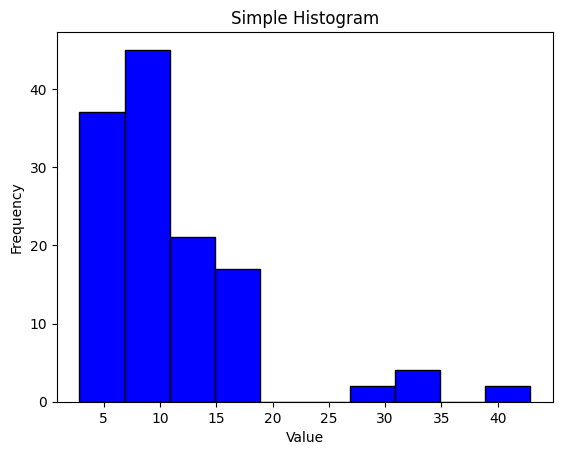

4/4 [==============================] - 0s 7ms/step
Epoch: 402/10000, D Loss: [0.69465864 0.4296875 ], G Loss: 0.2548488974571228, Val D Loss: [0.70128301 0.05078125]
4/4 [==============================] - 0s 7ms/step
Epoch: 403/10000, D Loss: [0.69597864 0.40234375], G Loss: 0.2546640932559967, Val D Loss: [0.70090973 0.0625    ]
4/4 [==============================] - 0s 10ms/step
Epoch: 404/10000, D Loss: [0.69581556 0.3984375 ], G Loss: 0.25483351945877075, Val D Loss: [0.70115837 0.06640625]
4/4 [==============================] - 0s 7ms/step
Epoch: 405/10000, D Loss: [0.69604594 0.3984375 ], G Loss: 0.25455692410469055, Val D Loss: [0.70078546 0.07421875]
4/4 [==============================] - 0s 6ms/step
Epoch: 406/10000, D Loss: [0.69550645 0.41796875], G Loss: 0.2561141848564148, Val D Loss: [0.70097542 0.05859375]
4/4 [==============================] - 0s 6ms/step
Epoch: 407/10000, D Loss: [0.69707686 0.3828125 ], G Loss: 0.25531747937202454, Val D Loss: [0.70121813 0.05078125]


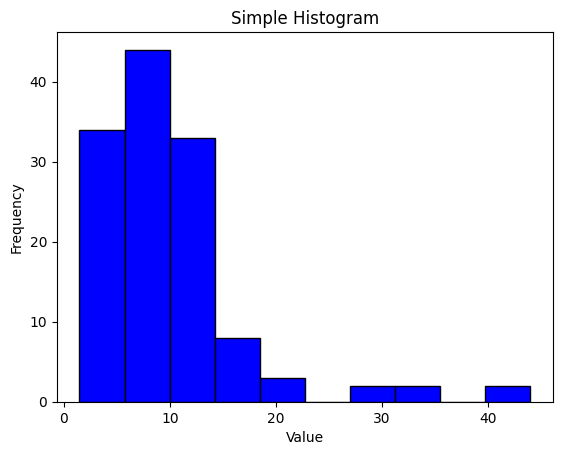

4/4 [==============================] - 0s 6ms/step
Epoch: 502/10000, D Loss: [0.69892365 0.40234375], G Loss: 0.25305432081222534, Val D Loss: [0.69882259 0.08984375]
4/4 [==============================] - 0s 7ms/step
Epoch: 503/10000, D Loss: [0.6994169 0.40625  ], G Loss: 0.25323760509490967, Val D Loss: [0.69968846 0.09765625]
4/4 [==============================] - 0s 7ms/step
Epoch: 504/10000, D Loss: [0.6993458 0.421875 ], G Loss: 0.252490758895874, Val D Loss: [0.69887832 0.10546875]
4/4 [==============================] - 0s 6ms/step
Epoch: 505/10000, D Loss: [0.6993742 0.4140625], G Loss: 0.25330471992492676, Val D Loss: [0.699604   0.12890625]
4/4 [==============================] - 0s 7ms/step
Epoch: 506/10000, D Loss: [0.69899    0.41796875], G Loss: 0.25212419033050537, Val D Loss: [0.69890481 0.16796875]
4/4 [==============================] - 0s 9ms/step
Epoch: 507/10000, D Loss: [0.6973436 0.453125 ], G Loss: 0.25335028767585754, Val D Loss: [0.69863054 0.0625    ]
4/4 [===

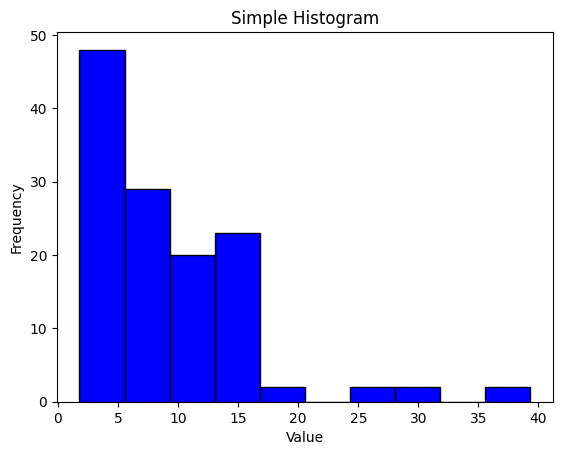

4/4 [==============================] - 0s 10ms/step
Epoch: 602/10000, D Loss: [0.700499   0.39453125], G Loss: 0.25206366181373596, Val D Loss: [0.69824877 0.05859375]
4/4 [==============================] - 0s 7ms/step
Epoch: 603/10000, D Loss: [0.7000067 0.421875 ], G Loss: 0.25135621428489685, Val D Loss: [0.6984852 0.1953125]
4/4 [==============================] - 0s 7ms/step
Epoch: 604/10000, D Loss: [0.69990146 0.4609375 ], G Loss: 0.25172749161720276, Val D Loss: [0.69785219 0.06640625]
4/4 [==============================] - 0s 9ms/step
Epoch: 605/10000, D Loss: [0.7003379  0.40234375], G Loss: 0.2522736191749573, Val D Loss: [0.6971004 0.1640625]
4/4 [==============================] - 0s 7ms/step
Epoch: 606/10000, D Loss: [0.6993406 0.4140625], G Loss: 0.25150322914123535, Val D Loss: [0.6988624 0.15625  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 607/10000, D Loss: [0.69905144 0.45703125], G Loss: 0.2524438500404358, Val D Loss: [0.69816577 0.09765625]
4/4 [====

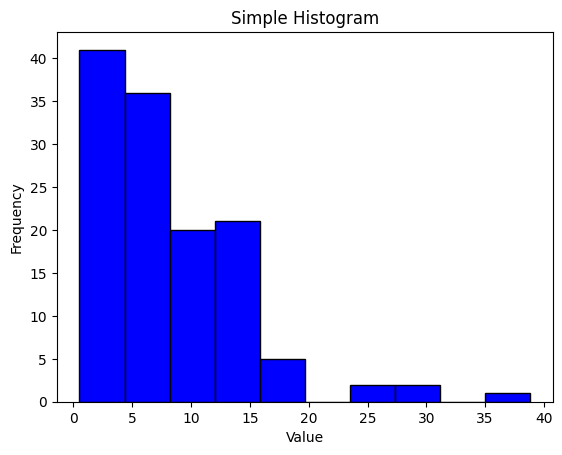

4/4 [==============================] - 0s 7ms/step
Epoch: 702/10000, D Loss: [0.69999224 0.3828125 ], G Loss: 0.25107333064079285, Val D Loss: [0.6974124  0.08984375]
4/4 [==============================] - 0s 6ms/step
Epoch: 703/10000, D Loss: [0.6999668  0.44140625], G Loss: 0.2510599195957184, Val D Loss: [0.69761577 0.16015625]
4/4 [==============================] - 0s 7ms/step
Epoch: 704/10000, D Loss: [0.7003799  0.44140625], G Loss: 0.2517484128475189, Val D Loss: [0.69700095 0.125     ]
4/4 [==============================] - 0s 6ms/step
Epoch: 705/10000, D Loss: [0.70106435 0.4140625 ], G Loss: 0.25209152698516846, Val D Loss: [0.69674847 0.15625   ]
4/4 [==============================] - 0s 10ms/step
Epoch: 706/10000, D Loss: [0.7003405 0.4375   ], G Loss: 0.2519299387931824, Val D Loss: [0.69741255 0.28515625]
4/4 [==============================] - 0s 7ms/step
Epoch: 707/10000, D Loss: [0.70013714 0.4375    ], G Loss: 0.2515314519405365, Val D Loss: [0.69790629 0.1484375 ]
4/4

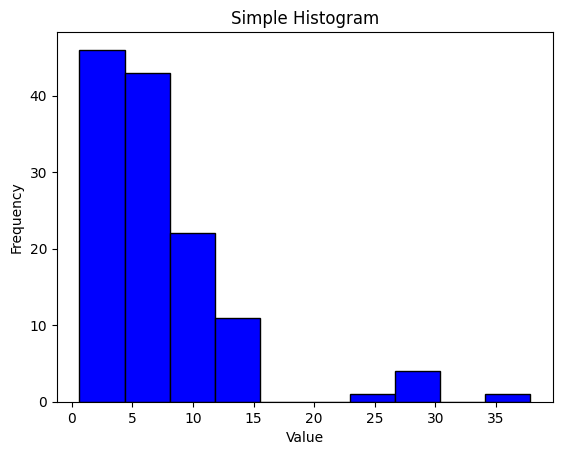

4/4 [==============================] - 0s 10ms/step
Epoch: 802/10000, D Loss: [0.7006551 0.453125 ], G Loss: 0.25126832723617554, Val D Loss: [0.69761699 0.07421875]
4/4 [==============================] - 0s 7ms/step
Epoch: 803/10000, D Loss: [0.7016618  0.42578125], G Loss: 0.2510913908481598, Val D Loss: [0.69726336 0.2734375 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 804/10000, D Loss: [0.70118195 0.4609375 ], G Loss: 0.2513730823993683, Val D Loss: [0.69754979 0.0625    ]
4/4 [==============================] - 0s 10ms/step
Epoch: 805/10000, D Loss: [0.70018744 0.4375    ], G Loss: 0.25141215324401855, Val D Loss: [0.695721 0.359375]
4/4 [==============================] - 0s 6ms/step
Epoch: 806/10000, D Loss: [0.69995165 0.42578125], G Loss: 0.25098133087158203, Val D Loss: [0.69752112 0.328125  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 807/10000, D Loss: [0.7007218 0.421875 ], G Loss: 0.25120168924331665, Val D Loss: [0.69751823 0.09765625]
4/4 [=

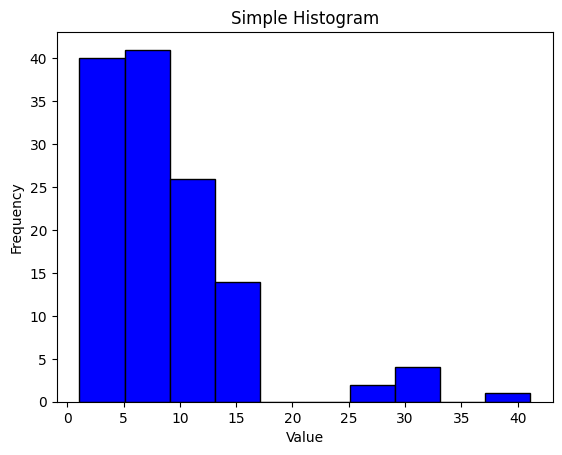

4/4 [==============================] - 0s 8ms/step
Epoch: 902/10000, D Loss: [0.69982076 0.50390625], G Loss: 0.25096115469932556, Val D Loss: [0.69756773 0.33203125]
4/4 [==============================] - 0s 7ms/step
Epoch: 903/10000, D Loss: [0.7009995 0.421875 ], G Loss: 0.25057345628738403, Val D Loss: [0.69858715 0.06640625]
4/4 [==============================] - 0s 8ms/step
Epoch: 904/10000, D Loss: [0.70168376 0.4296875 ], G Loss: 0.2514092028141022, Val D Loss: [0.69775727 0.10546875]
4/4 [==============================] - 0s 7ms/step
Epoch: 905/10000, D Loss: [0.7011512 0.3984375], G Loss: 0.25085920095443726, Val D Loss: [0.69803739 0.0625    ]
4/4 [==============================] - 0s 7ms/step
Epoch: 906/10000, D Loss: [0.7011777 0.390625 ], G Loss: 0.2510727047920227, Val D Loss: [0.69743299 0.0625    ]
4/4 [==============================] - 0s 14ms/step
Epoch: 907/10000, D Loss: [0.70110667 0.42578125], G Loss: 0.2509748935699463, Val D Loss: [0.69771546 0.04296875]
4/4 [=

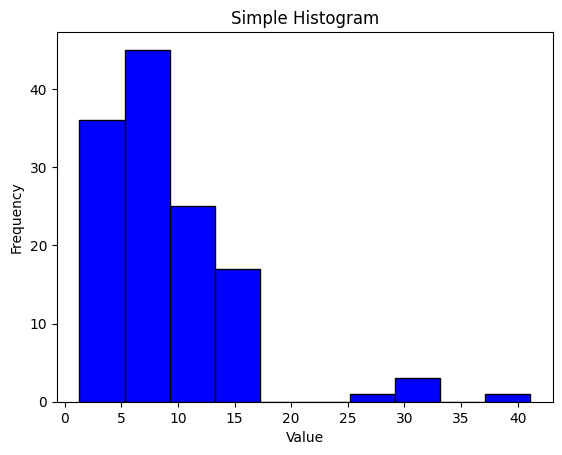

4/4 [==============================] - 0s 7ms/step
Epoch: 1002/10000, D Loss: [0.7015189  0.39453125], G Loss: 0.25039371848106384, Val D Loss: [0.69805658 0.07421875]
4/4 [==============================] - 0s 7ms/step
Epoch: 1003/10000, D Loss: [0.7001327 0.4609375], G Loss: 0.25093701481819153, Val D Loss: [0.69780594 0.26953125]
4/4 [==============================] - 0s 10ms/step
Epoch: 1004/10000, D Loss: [0.70086175 0.4375    ], G Loss: 0.2507706880569458, Val D Loss: [0.69796416 0.0703125 ]
4/4 [==============================] - 0s 10ms/step
Epoch: 1005/10000, D Loss: [0.700711 0.421875], G Loss: 0.25099512934684753, Val D Loss: [0.69748029 0.09375   ]
4/4 [==============================] - 0s 7ms/step
Epoch: 1006/10000, D Loss: [0.70176697 0.4296875 ], G Loss: 0.25066447257995605, Val D Loss: [0.69768083 0.14453125]
4/4 [==============================] - 0s 7ms/step
Epoch: 1007/10000, D Loss: [0.69955164 0.45703125], G Loss: 0.25154709815979004, Val D Loss: [0.69819897 0.0507812

KeyboardInterrupt: 

In [103]:
# Train the GAN with validation
import matplotlib.pyplot as plt

train_gan(generator, discriminator, gan, epochs=10000, batch_size=128, latent_dim=latent_dim, val_gen=val_gen)

In [70]:
n_samp = 1024*8
# latent_dim
n_lowest = 10
result_vec = []
noise = tf.random.normal(shape=(n_samp, latent_dim))
synthetic_samples = generator.predict(noise)
batch_val = next(val_gen)
for batch_ in batch_val:
  # batch_ = batch_val[1]
  match_indices = [0,1,2,3,5,6,7,8,9]

  data = [np.mean(np.sqrt((batch_[match_indices] - samp[match_indices])**2)) for samp in synthetic_samples]

  indices = sorted(range(len(data)), key=lambda i: data[i])[:n_lowest]

  most_similar = [synthetic_samples[i] for i in indices]

  most_similar_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in most_similar]

  original_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in [batch_]]
  # most_similar_scaled_df = pd.DataFrame(most_similar_scaled, columns=numeric_cols.columns)

  most_similar_scaled_2d = [np.squeeze(sim) for sim in most_similar_scaled]

  original_scaled_2d = [np.squeeze(sim) for sim in original_scaled]

  most_similar_scaled_df = pd.DataFrame(most_similar_scaled_2d, columns=numeric_cols.columns)

  original_scaled_df = pd.DataFrame(original_scaled_2d, columns=numeric_cols.columns)

  result = np.sqrt((np.mean(most_similar_scaled_df['imp_c_float'])- np.mean(original_scaled_df['imp_c_float']))**2)/np.mean(original_scaled_df['imp_c_float'])
  # print(np.mean(original_scaled_df['agbd_m']))
  result_vec.append(result)

256/256 [==============================] - 2s 7ms/step


In [75]:
most_similar

[array([ 28.531334 , -11.202219 , -40.439777 , -10.090137 ,   8.2734   ,
         -9.428419 ,  11.930028 ,   1.0942104, -22.76571  ,   8.018955 ],
       dtype=float32),
 array([ 26.278467 , -13.948817 , -43.122784 , -13.704297 ,  -0.3593356,
         -0.880978 ,  17.13365  ,  -4.0011663, -16.45799  ,   8.377134 ],
       dtype=float32),
 array([ 27.357634 , -13.8198805, -42.084545 , -13.7134905,   2.781976 ,
         -1.5432317,  15.445559 ,  -6.4791827, -18.052958 ,   7.3337617],
       dtype=float32),
 array([ 30.264784 , -11.677847 , -41.794704 , -11.004966 ,   6.7667494,
         -6.901617 ,  12.113672 ,  -2.4122186, -23.751757 ,   7.4664197],
       dtype=float32),
 array([ 2.7120161e+01, -1.5374141e+01, -4.3389359e+01, -1.3616334e+01,
         4.1027898e-01,  2.4836615e-02,  1.7055265e+01, -6.4799428e+00,
        -1.6840025e+01,  8.7692604e+00], dtype=float32),
 array([ 26.57422  , -14.09194  , -42.864433 , -14.682696 ,  -1.7990932,
          2.1483393,  17.79635  ,  -7.8763576,